# Routing around obstacles

## Example problem

We'll have one route (a straight line) and two obstacles (a polygon and a circle) the first of which is crossed by the line multiple times.

In [1]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from matplotlib import pyplot as plt
import string

In [2]:
# straight path
line = LineString([(0, 2), (3, 2)])

# large obstacle which is touched by the straight path
poly_0 = Polygon([(1, 1), (1.5, 2.5), (2, 1), (2, 3), (1, 3), (1, 1)])

# small obstacle which just further complicates stuff
poly_1 = Point(1.5, 2.15).buffer(0.03)

In [3]:
all_points = set()

# original objects
all_points = all_points.union(set(list(zip(*poly_0.exterior.xy))))
all_points = all_points.union(set(list(zip(*line.xy))))

# intersection points
for n, g in enumerate(poly_0.difference(line.buffer(0.001)).geoms):
    all_points = all_points.union(set(list(zip(*g.exterior.xy))))

# round to get rid of degenerate points
all_points = set(map(lambda p: tuple(map(lambda t: round(t, 2), p)), all_points))

# sort from lower left corder to upper right corner
all_points = sorted(all_points)

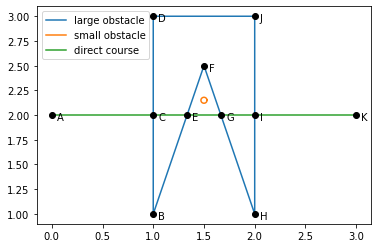

In [4]:
plt.plot(*poly_0.exterior.xy, label="large obstacle")
plt.plot(*poly_1.exterior.xy, label="small obstacle")
plt.plot(*line.xy, label="direct course")

for lab, p in zip(string.ascii_uppercase, all_points):
    plt.plot(*p, 'ko')
    plt.annotate(
        lab,
        xy=p, xycoords='data',
        xytext=(5, -5), textcoords='offset points',
    )    

plt.legend(loc=2);

## Automatically solving the graph

Based on the above image, we'll create a graph which can distinguish different edges between the same pair of nodes (e.g. `CE` and `CBE` both go from `C` to `E`).
But we won't use shapely objects for building the network yet.

In [5]:
import networkx

In [6]:
g = networkx.MultiGraph()

### Construct graph by defining all edges

We'll add keys indicating the points belonging to the edge and whether tha path is over land or through water.

In [7]:
g.add_edge("A", "C", key=("AC", "water"))

g.add_edge("C", "E", key=("CBE", "water"))
g.add_edge("C", "E", key=("CE", "land"))

g.add_edge("E", "G", key=("EG", "water"))
g.add_edge("E", "G", key=("EFG", "water"))

g.add_edge("G", "I", key=("GHI", "water"))
g.add_edge("G", "I", key=("GI", "land"))

g.add_edge("C", "I", key=("CDJI", "water"))

g.add_edge("I", "K", key=("IK", "water"));

Note that here all that is needed is that the start and end and the key is hashable. So with hashable types for shapely `Point` and `LineString`, we could directly use them here.

### Remove edges which touch land

In [8]:
def is_land_edge(edge):
    return edge[2][1] == "land"

In [9]:
land_edges = list(filter(is_land_edge, g.edges))
g.remove_edges_from(land_edges)

### Show remaining graph

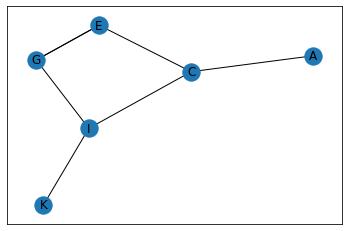

In [10]:
networkx.draw_networkx(g)

In [11]:
display(list(g.edges))

[('A', 'C', ('AC', 'water')),
 ('C', 'E', ('CBE', 'water')),
 ('C', 'I', ('CDJI', 'water')),
 ('E', 'G', ('EG', 'water')),
 ('E', 'G', ('EFG', 'water')),
 ('G', 'I', ('GHI', 'water')),
 ('I', 'K', ('IK', 'water'))]

### Find all paths from start to end (A to K)

In [12]:
for p in networkx.all_simple_edge_paths(g, "A", "K"):
    print(list(map(lambda _p: _p[2][0], p)))

['AC', 'CBE', 'EG', 'GHI', 'IK']
['AC', 'CBE', 'EFG', 'GHI', 'IK']
['AC', 'CDJI', 'IK']


## Build same graph with shapely objects

### Hashable geometries

As shapely's geometries are not hashable, we'll create hashable subclasses first.

In [13]:
class PointHash(Point):
    def __hash__(self):
        return hash(self.coords[0])
    
    
class LineStringHash(LineString):
    def __hash__(self):
        return hash(tuple(self.coords))

### Finding all segments

In [14]:
from shapely.ops import split

In [15]:
def get_all_poly_segments(poly=None, line=None):
    # split polygon into sub-polygons
    splits_0 = list(split(poly, line).geoms)
    
    # if only one resulting polygon, we're done here, return empty
    if len(splits_0) == 1:
        return []
    
    # turn polygons into line strings without the part covered by line
    splits_1 = [sp.exterior.difference(line) for sp in splits_0]
    
    # split possible line collections
    splits_2 = []
    for sp in splits_1:
        if hasattr(sp, "geoms"):
            for g in sp.geoms:
                splits_2.append(g)
        else:
            splits_2.append(sp)
        
    return splits_2

In [16]:
def get_all_line_segments(line=None, poly=None):
    # split polygon into sub-polygons
    splits_0 = list(split(line, poly).geoms)
    
    # if only one resulting polygon, we're done here, return empty
    if len(splits_0) == 1:
        return []
    
    # split possible line collections
    splits_1 = []
    for sp in splits_0:
        if hasattr(sp, "geoms"):
            for g in sp.geoms:
                splits_1.append(g)
        else:
            splits_1.append(sp)
        
    return list(zip(splits_1, map(lambda l: l.intersects(poly.buffer(-1.0e-7)), splits_1)))

In [17]:
all_poly_segments = (
    get_all_poly_segments(poly_0, line)
    + get_all_poly_segments(poly_1, line)
)
all_poly_segments

In [18]:
all_line_segments = (
    get_all_line_segments(line, poly_0)
    + get_all_line_segments(line, poly_1)
)
all_line_segments

[(<shapely.geometry.linestring.LineString at 0x7f6cdaea5610>, False),
 (<shapely.geometry.linestring.LineString at 0x7f6cdaea55e0>, True),
 (<shapely.geometry.linestring.LineString at 0x7f6cdaea5310>, False),
 (<shapely.geometry.linestring.LineString at 0x7f6cdaea52e0>, True),
 (<shapely.geometry.linestring.LineString at 0x7f6cdaea5670>, False)]

## Put into graph

In [19]:
def get_start_end(line):
    return line.coords[0], line.coords[-1]

In [20]:
gg = networkx.MultiGraph()

In [21]:
for seg in all_poly_segments:
    gg.add_edge(
        PointHash(get_start_end(seg)[0]),
        PointHash(get_start_end(seg)[1]),
        key=LineStringHash(seg),
    )
    
for seg in all_line_segments:
    # skip if over land
    if seg[1]:
        continue
    gg.add_edge(
        PointHash(get_start_end(seg[0])[0]),
        PointHash(get_start_end(seg[0])[1]),
        key=LineStringHash(seg[0]),
    )

In [22]:
len(gg.edges)

7

In [28]:
len(gg.nodes)

6

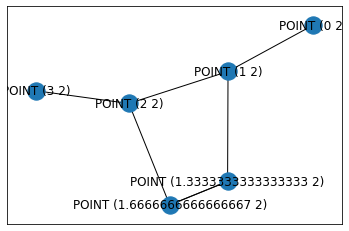

In [29]:
networkx.draw_networkx(gg)

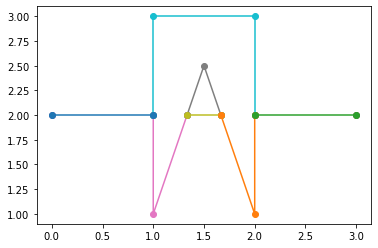

In [25]:
for n in gg.nodes:
    plt.plot(*n.xy, 'o')
    
for e in gg.edges:
    plt.plot(*e[2].xy, 'o-')

### Find all paths

In [26]:
from shapely.ops import linemerge

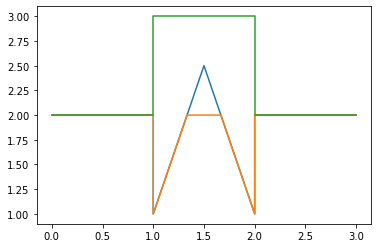

In [31]:
for _p in networkx.all_simple_edge_paths(gg, PointHash(0, 2), PointHash(3, 2)):
    plt.plot(*linemerge([_l[2] for _l in _p]).xy)